# Correlation analysis between chlorophyll a (indicator for marine plants) and seawater temperature 

This report analyzes a possible correlation between chlorophyll a in seawater in the North and Baltic Seas of Germany which indicates changes in marine plants like phytoplankton and seawater temperature. It uses open data from Mobilithek (https://data.bsh.de/OpenData/DOD/MO_H_CHLA/ and https://data.bsh.de/OpenData/DOD/MO_H_TEMP/) for the analysis.
The data is licensed under following license:
License: GeoSeaPortal des BSH, licensed under the following license: Data licence Germany – attribution – Version 2.0" or "dl-de/by-2-0" referring to the licence text available at www.govdata.de/dl-de/by-2-0, data available at https://data.bsh.de/OpenData/DOD/MO_H_CHLA/ 

## Install dependencies
Initially, install all required dependencies. 

In [ ]:
%pip install pandas
%pip install matplotlib
%pip install numpy

## Load data
Create a pandas dataframe using the local sqlite file.

In [38]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import math
import calendar

con = sqlite3.connect('./data/data.sqlite')
df1 = pd.read_sql_query("SELECT * FROM CHLA_18", con)
df2 = pd.read_sql_query("SELECT * FROM CHLA_22", con)
df3 = pd.read_sql_query("SELECT * FROM TEMP_18", con)
df4 = pd.read_sql_query("SELECT * FROM TEMP_22", con)

## How have the chlorophyl a and temperature levels in the North and Baltic Seas of Germany changed?
In this report, data from 2018 is compared to data from 2022. The first figure illustrates the changes in temperature. The second figure displays the variations in chlorophyll a levels. It can be observed that the average temperature has risen and the average chlorophyll a level has decreased. The initial assumption is that when temperature increases, chlorophyll a decreases, and vice versa. Figure 3 and 4 show whether this assumption holds within a year. Red circles indicate the begin and end of instances where this assumption does not hold.

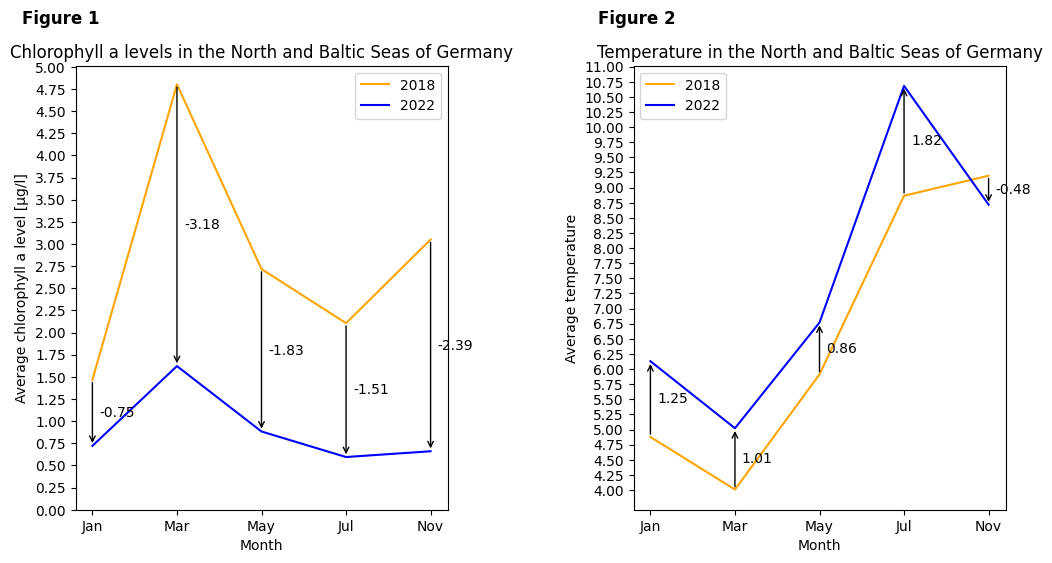

In [123]:
def process_data(df, column, alt_column):
    data = []
    for d in range(len(df)):
        if not math.isnan(df[column][d]):
            data.append(df[column][d])
        else:
            data.append(df[alt_column][d])
    df = df.assign(data=data)
    return df

def plot_data(ax, df1, df2, title, ylabel, legend):
    df1_grouped = df1.groupby(pd.PeriodIndex(df1['Date'], freq="M"))["data"].mean()
    df2_grouped = df2.groupby(pd.PeriodIndex(df2['Date'], freq="M"))["data"].mean()

    months = [1, 3, 5, 7, 11]
    df1_data = df1_grouped[df1_grouped.index.month.isin(months)]
    df2_data = df2_grouped[df2_grouped.index.month.isin(months)]

    ax.plot(df1_data.values, color='orange')
    ax.plot(df2_data.values, color='blue')
    ax.legend(legend)
    month_labels = [calendar.month_abbr[month] for month in df1_data.index.month]
    ax.set_xticks(range(len(df1_data.index)))
    ax.set_xticklabels(month_labels)
    ax.set_xlabel('Month')
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    y_min = min(np.min(df1_data.values), np.min(df2_data.values))
    y_max = max(np.max(df1_data.values), np.max(df2_data.values))
    y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + 0.25, 0.25)
    ax.set_yticks(y_ticks)

def plot_differences(ax, df1, df2):
    df1_grouped = df1.groupby(pd.PeriodIndex(df1['Date'], freq="M"))["data"].mean()
    df2_grouped = df2.groupby(pd.PeriodIndex(df2['Date'], freq="M"))["data"].mean()

    months = [1, 3, 5, 7, 11]
    df1_data = df1_grouped[df1_grouped.index.month.isin(months)]
    df2_data = df2_grouped[df2_grouped.index.month.isin(months)]

    differences = df2_data.values - df1_data.values

    for i, diff in enumerate(differences):
        arrow_color = 'black'
        x1 = i
        y1 = df1_data.values[i]
        x2 = i
        y2 = df2_data.values[i]
        ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                     arrowprops=dict(arrowstyle='->', color=arrow_color, linewidth=1))

        # Calculate the x-coordinate for the difference annotation
        x_diff = (x1 + x2) / 2
        # Calculate the y-coordinate for the difference annotation
        y_diff = (y1 + y2) / 2

        # Add the difference annotation
        ax.annotate(f"{diff:.2f}", xy=(x_diff, y_diff), xytext=(5, 0),
                     textcoords="offset points", ha='left', va='center')

# Convert datetime for df1 and df2
pd.to_datetime(df1.Date)
pd.to_datetime(df2.Date)

# Process data for chlorophyll a in df1 and df2
df1 = process_data(df1, "CHLA_SENE_DEV_NDT [µg/l]", "CHLA_FLM_FGN_AL [µg/l]")
df2 = process_data(df2, "CHLA_SENE_DEV_NDT [µg/l]", "CHLA_WAS_PTM_F_ACE [µg/l]")

# Convert datetime for df3 and df4
pd.to_datetime(df3.Date)
pd.to_datetime(df4.Date)

# Process data for temperature in df3 and df4
df3 = process_data(df3, "TEMP_THE_NOT_NDT[°C]", "TEMP_THEPRC_NOT_NDT[°C]")
df4 = process_data(df4, "TEMP_THE_NOT_NDT[°C]", "TEMP_SBE9_THEPRC_DEV_NDT")

# Create subplots for the two graphs with spacing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'wspace': 0.5})

# Plot chlorophyll a data and differences
plot_data(ax1, df1, df2, 'Chlorophyll a levels in the North and Baltic Seas of Germany',
          'Average chlorophyll a level [µg/l]', ['2018', '2022'])
plot_differences(ax1, df1, df2)

# Plot temperature data and differences
plot_data(ax2, df3, df4, 'Temperature in the North and Baltic Seas of Germany',
          'Average temperature', ['2018', '2022'])
plot_differences(ax2, df3, df4)

# Adjust the layout for better visibility of annotations
plt.subplots_adjust(top=0.85)

# Add figure numbers
fig.text(0.08, 0.92, 'Figure 1', fontsize=12, fontweight='bold')
fig.text(0.56, 0.92, 'Figure 2', fontsize=12, fontweight='bold')

# Display the plot
plt.show()


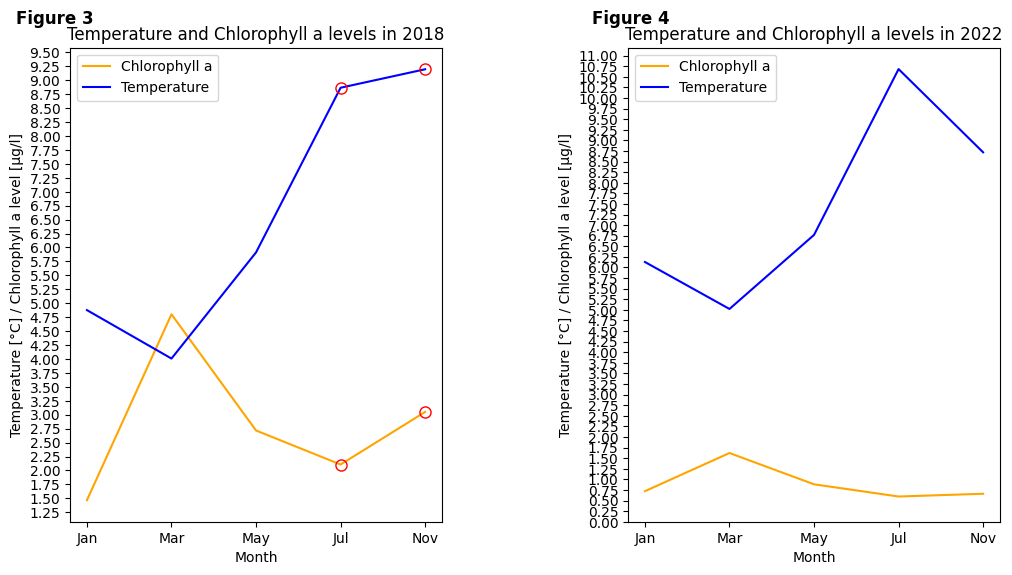

In [156]:
def mark_data(ax, df1, df2):
    df1_grouped = df1.groupby(pd.PeriodIndex(df1['Date'], freq="M"))["data"].mean()
    df2_grouped = df2.groupby(pd.PeriodIndex(df2['Date'], freq="M"))["data"].mean()

    months = [1, 3, 5, 7, 11]
    df1_data = df1_grouped[df1_grouped.index.month.isin(months)]
    df2_data = df2_grouped[df2_grouped.index.month.isin(months)]


    for i in range(len(df1_data.index) - 1):  # Iterate up to the second-to-last data point
         if df1_data.values[i] > df1_data.values[i+1] and df2_data.values[i] >  df2_data.values[i + 1]:
            ax.plot(i, df1_data.values[i], marker='o', markersize=8, color='red', fillstyle='none')
            ax.plot(i+1, df1_data.values[i+1], marker='o', markersize=8, color='red', fillstyle='none')
            ax.plot(i, df2_data.values[i], marker='o', markersize=8, color='red', fillstyle='none')
            ax.plot(i+1, df2_data.values[i+1], marker='o', markersize=8, color='red', fillstyle='none')
         elif df1_data.values[i] < df1_data.values[i+1] and df2_data.values[i] <  df2_data.values[i + 1]:
             ax.plot(i, df1_data.values[i], marker='o', markersize=8, color='red', fillstyle='none')
             ax.plot(i+1, df1_data.values[i+1], marker='o', markersize=8, color='red', fillstyle='none')
             ax.plot(i, df2_data.values[i], marker='o', markersize=8, color='red', fillstyle='none')
             ax.plot(i+1, df2_data.values[i+1], marker='o', markersize=8, color='red', fillstyle='none')

    
# Create subplots for the two graphs with spacing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'wspace': 0.5})

# Plot temperature data and differences for 2018
plot_data(ax1, df1, df3, 'Temperature and Chlorophyll a levels in 2018',
          'Temperature [°C] / Chlorophyll a level [µg/l]', ['Chlorophyll a', 'Temperature'])

# Mark lines with red circles if assumption doesn't match for 2018
mark_data(ax1, df1, df3)

# Plot temperature data and differences for 2022
plot_data(ax2, df2, df4, 'Temperature and Chlorophyll a levels in 2022',
          'Temperature [°C] / Chlorophyll a level [µg/l]', ['Chlorophyll a', 'Temperature'])

# Mark lines with red circles if assumption doesn't match for 2022
mark_data(ax2, df2, df4)

# Adjust the layout for better visibility of annotations and circles
plt.subplots_adjust(top=0.9)

# Add figure numbers
fig.text(0.08, 0.94, 'Figure 3', fontsize=12, fontweight='bold')
fig.text(0.56, 0.94, 'Figure 4', fontsize=12, fontweight='bold')

# Display the plot
plt.show()


## Interpretation of the results
Since 2018, the sea water temperature has changed, and the chlorophyll a level has decreased (Figures 1 and 2). Figures 3 and 4 demonstrate that, with one exception, our assumption holds. The rising temperature has an impact on the quantity of marine plants (for further information, see https://link.springer.com/article/10.1007/s00442-018-4084-8). Considering that chlorophyll a serves as an indicator for marine plants (for further information, see https://earthobservatory.nasa.gov/global-maps/MY1DMM_CHLORA), this analysis also indicates a decline in the amount of marine plants in the North and Baltic Seas of Germany.